# 6.6 Sourcing & Analyzing Time Series Data 

## Table of contents:
### 1.Importing Libraries
### 2. Importing Data
### 3. Subsetting, Wrangling & Plotting
### 4. Time-series Analysis
#### 4.1 Decomposition
#### 4.2 Stationarity Test
#### 4.3 Autocorrelation Test
### 5. Stationarizing Data
### 6. Testing: second round
#### 6.1 Stationarity Test
### 7. Stationarizing data: second round
### 8. Testing: third round
#### 8.1 Stationarity Test
#### 8.2 Autocorrelation Test

# 1. Importing Libraries

In [2]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os
from datetime import datetime
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

# 2. Importing Data

#### Since the only time variable that I have in my previous used dataframe is in the "year" and not in the "year-month-day" format, I have to use a different dataset for this task. 
#### I chose the following Quandl dataset, available at this link:
https://data.nasdaq.com/data/BP/C02_EMMISSIONS_USA-carbon-dioxide-co2-emmissions-usa.

#### This time series entails total CO2 emissions for the USA recorded by year from 1965 to 2020.

In [3]:
# Configure my API key

quandl.ApiConfig.api_key = 'eKFSs66K_4keXHB_DfvU'

In [4]:
# Import the dataframe from "Energy consumption and production - Carbon Dioxide (CO2) Emmissions - USA"

data_co2 = quandl.get('BP/C02_EMMISSIONS_USA')

In [5]:
# Print the first 5 rows

data_co2.head()

,Value
Date,
1965-12-31,3451.891855
1966-12-31,3639.795004
1967-12-31,3738.161319
1968-12-31,3947.343459
1969-12-31,4117.396247


#### You can see that the data contains the yearly amount of USA CO2 emissions (from 1965 to 2020).

In [6]:
# Check the size 

data_co2.shape

(56, 1)

In [7]:
# Check the columns

data_co2.columns

Index(['Value'], dtype='object')

In [8]:
# Check the type

type(data_co2)

pandas.core.frame.DataFrame

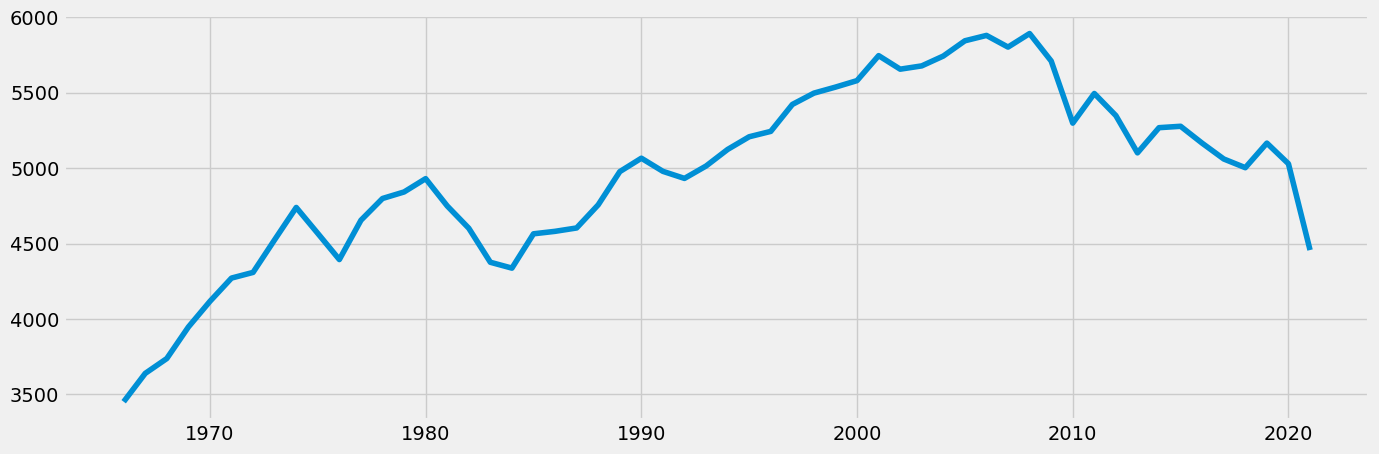

In [9]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data_co2)

#### There is a general upward trend with some fluctuations from 1965 to 2008 and a descending trend from 2008 to 2020.

# 3. Subsetting, Wrangling & Plotting

#### For the time series analysis I decided to subset this dataframe and limit it to records from 1980 to 2020 to include more recent data. To achieve this, I have to reset the index to change "Date" from index to a variable.

In [10]:
# Create a new subset, reset the index

data_co2_ind = data_co2.reset_index()

In [11]:
# Check the results

data_co2_ind.head()

,Date,Value
0,1965-12-31,3451.891855
1,1966-12-31,3639.795004
2,1967-12-31,3738.161319
3,1968-12-31,3947.343459
4,1969-12-31,4117.396247


#### The index has been reset sucessfully and "Date" is a variable now. The next step is to subset the dataframe by utilizing the loc function.

In [12]:
# Filter the date variable

data_co2_sub = data_co2_ind.loc[(data_co2_ind['Date'] >= '1980-12-31')]

In [13]:
# Checking the size of the subset

data_co2_sub.shape

(41, 2)

#### As expected the subset contains 15 records less than the original dataframe.

In [14]:
# Check the first 5 rows of the subset

data_co2_sub.head()

,Date,Value
15,1980-12-31,4749.345114
16,1981-12-31,4601.680051
17,1982-12-31,4376.272973
18,1983-12-31,4337.413667
19,1984-12-31,4564.867043


#### This looks like expected. The dataframe starts with the year 1980. Next step is to replace the current index with the "Date" column using "datetime".

In [15]:
# Set the "Date" column as the index

data_co2_sub['datetime'] = pd.to_datetime(data_co2_sub['Date']) # Creating a "datetime" column from "Date" column.
data_co2_sub = data_co2_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_co2_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_co2_sub.head()

,Value
datetime,
1980-12-31,4749.345114
1981-12-31,4601.680051
1982-12-31,4376.272973
1983-12-31,4337.413667
1984-12-31,4564.867043


#### This looks as expected. Next steps are to check for missing values and duplicates.

In [16]:
# Check for missing values

data_co2_sub.isnull().sum() 

Value    0
dtype: int64

#### There are no missing values.

In [17]:
# Check for duplicates

dups = data_co2_sub.duplicated()
dups.sum()

0

#### There are no duplicates.

#### Now we are ready to plot our time series. 

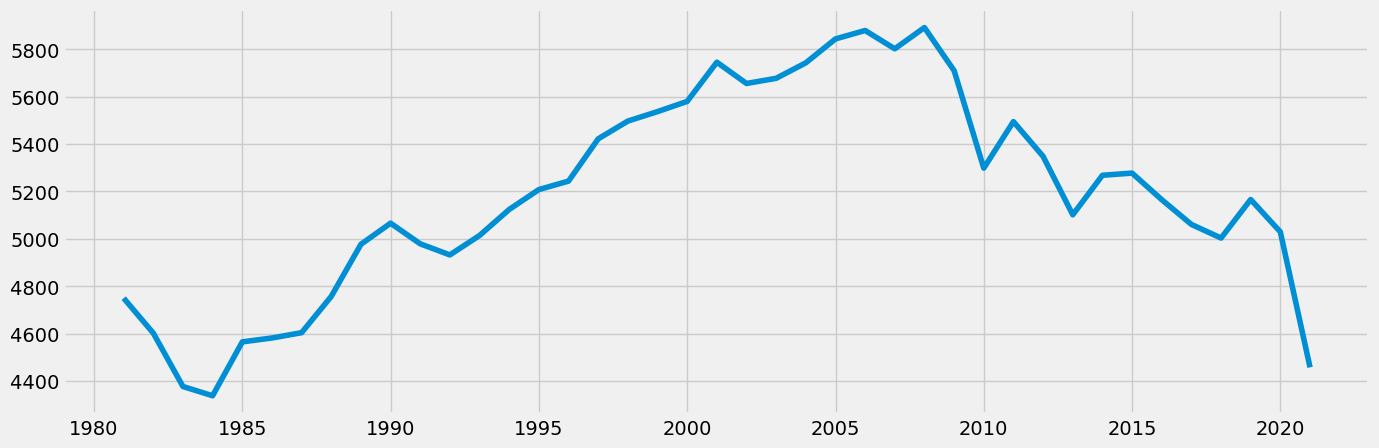

In [18]:
# Plot the subset

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_co2_sub)

#### With the exception of some fluctuations, we can observe a general upward trend from 1985 to 2008. From 2008 to 2020 there is a downward trend. 

# 4. Time-series Analysis

## 4.1 Decomposition

#### The first step in the analysis is to decompose our time series to help us understand if the data is stationary or non-stationary.
#### Based on the chart above, it seems that the data is non-linear and therefore a multiplicative method should be used.

In [19]:
# Decompose the time series using a multiplicative model

decomposition = sm.tsa.seasonal_decompose(data_co2_sub, model='multiplicative')

In [20]:
# Set a fixed size for all charts

rcParams['figure.figsize'] = 18, 7

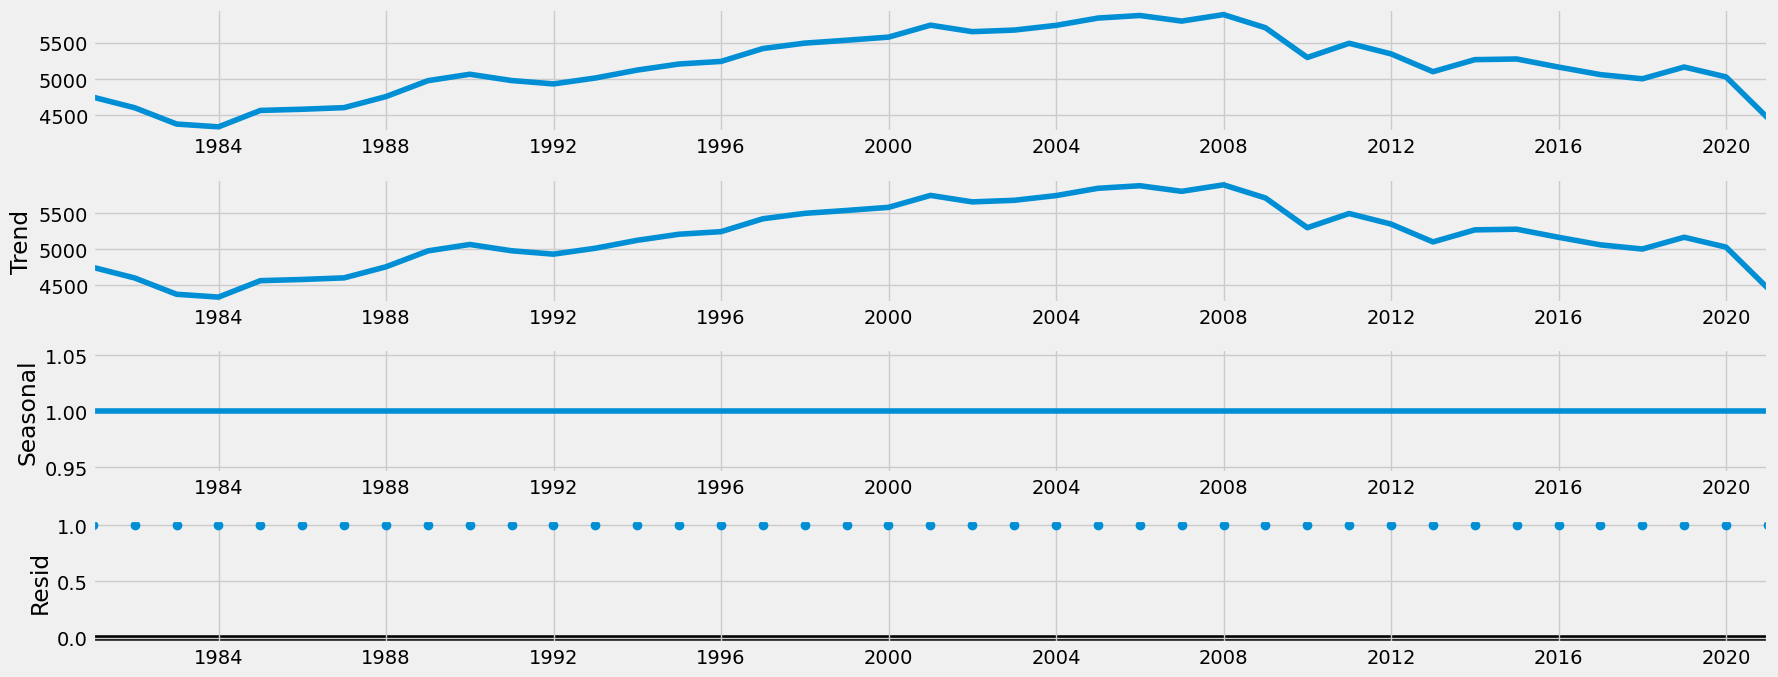

In [21]:
# Plot the decomposed components

decomposition.plot()
plt.show()

#### Let's analyze the results of the plot:
#### The time series is smooth for the most part (yearly frequency) and the trend is basically equal to the level. The trend gradually increases until 2008 and then gradually decreases until 2020. 
#### The seasonality line is flat which would imply that there isn't a seasonality component in the time series. 
#### It also seems that there isn't any noise in the series  which could be expected after smoothing the data.
#### Overall, this just gave us an overview and we cannot affirm  yet if our time sereis is stationary or not. 
#### We are going to run a stationarity test next to gain more information.

## 4.2 Stationarity Test

#### We should run a statistical test to get a better idea of the nature of our data. The Dickey-Fuller test checks if data contains a unit root, an indicator of non-stationarity.
#### But before conducting the test, I  determine the following hypotheses:

* Null hypothesis: The data contains a unit root (is non-stationary)
* Alternative hypothesis: The data doesn't contain a unit root (is stationary)

#### First, let's define a custom function which can be applied to our time series subsequently.

In [22]:
# Define the function

def dickey_fuller(timeseries):
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series

dickey_fuller(data_co2_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.343613
p-value                         0.608991
Number of Lags Used             8.000000
Number of Observations Used    32.000000
Critical Value (1%)            -3.653520
Critical Value (5%)            -2.957219
Critical Value (10%)           -2.617588
dtype: float64


#### Interpretation of the test results:
#### For a "significant result", the p-value should be less than 0,05, but in our case it is 0,6 which is too high.
#### Also, the Test Statistic value (-1.34) is bigger than the Critical Value (5%) with -2.96. But to reject the Null hypothesis we aim for a Test statistic value smaller than the Critical Value. So according to the test we can't reject the Null hypothsis and our time series seems to be non-stationary. 

#### Next, we are going to run a autocorrelation test before stationarizing the time series.

## 4.3 Autocorrelation Test

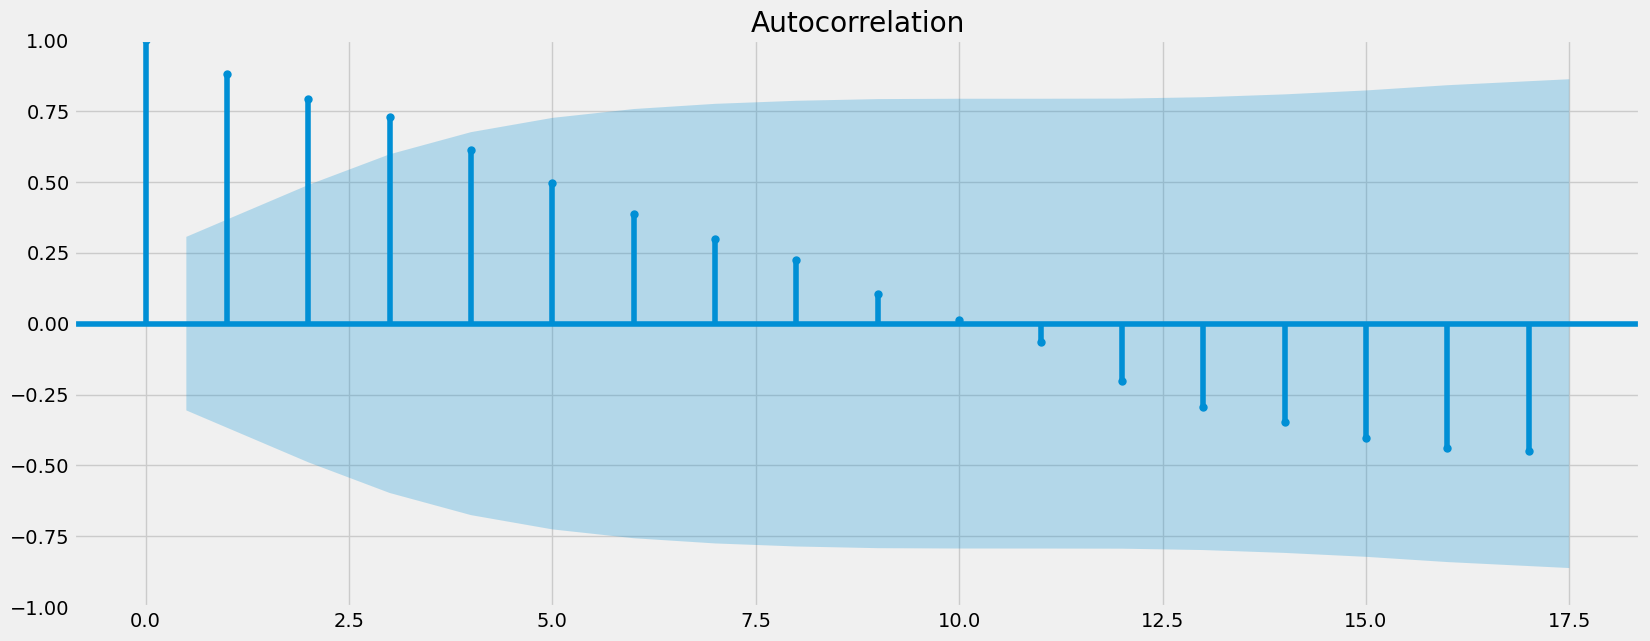

In [23]:
# Run the autocorrelation test

plot_acf(data_co2_sub)
plt.show()

#### There are 4 lags above the blue confidence interval, which means there seems to be some autocorrelation. 
#### I will run another autocorrelation test after stationarizing the time series data.

# 5. Stationarizing Data

#### I will create a new dataframe to stationarize the time series and use the differencing method.

In [24]:
# Use the differencing method

data_co2_stat = data_co2_sub - data_co2_sub.shift(1)

#### When using the differencing method NaN values can be generated. If that is the case here, I will remove them.

In [25]:
# Remove NaN values

data_co2_stat.dropna(inplace = True)

In [26]:
# Check the first 5 rows

data_co2_stat.head()

,Value
datetime,
1981-12-31,-147.665062
1982-12-31,-225.407078
1983-12-31,-38.859306
1984-12-31,227.453376
1985-12-31,16.436492


#### Let's plot a new chart and see how the time series looks like now.

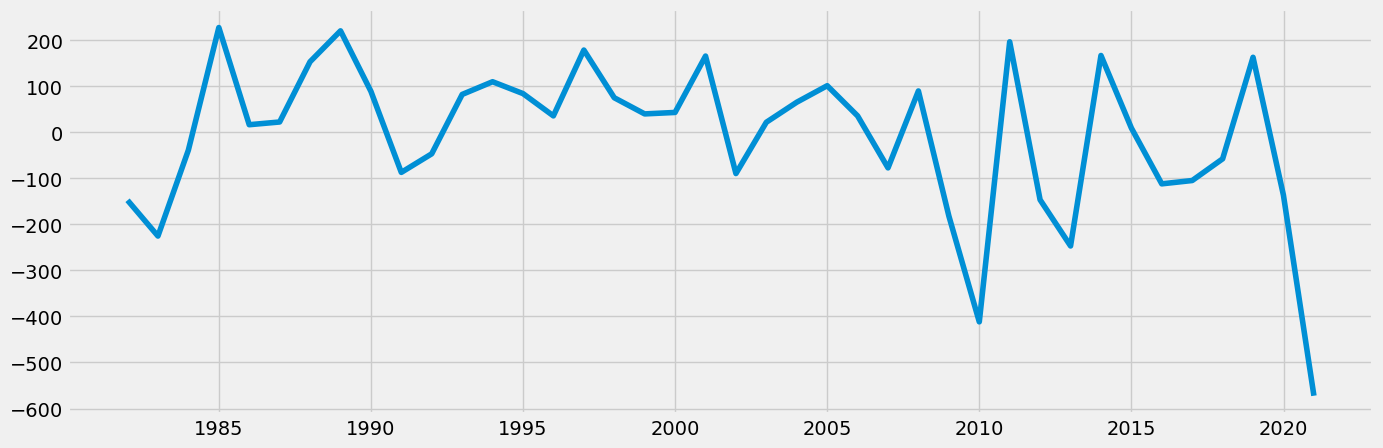

In [27]:
# Plot the new time series

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_co2_stat)

#### This looks different than before! To find out if it is stationary we need to run another test.

# 6. Testing: second round

## 6.1 Stationarity Test

#### Our null hypothesis and alternative hypothesis stay the same and we already defined the function. Let's run the Dickey-Fuller test to our new time series.

In [28]:
# Apply the Dickey-Fuller test

dickey_fuller(data_co2_stat['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -2.106319
p-value                         0.241981
Number of Lags Used             2.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


#### Interpretation of the test results:
#### The p-value is still bigger than 0,05.
#### The Test Statistic value is still bigger than the Critical Value. 
#### That means we need to perform another round of differencing.

# 7. Stationarizing data: second round

In [29]:
# Create a new dataframe and use the differencing method

data_co2_stat_2 = data_co2_stat - data_co2_stat.shift(1)

In [30]:
# Remove NaNs

data_co2_stat_2.dropna(inplace = True)

In [31]:
# Checking the first 5 rows

data_co2_stat_2.head()

,Value
datetime,
1982-12-31,-77.742016
1983-12-31,186.547772
1984-12-31,266.312682
1985-12-31,-211.016884
1986-12-31,5.899999


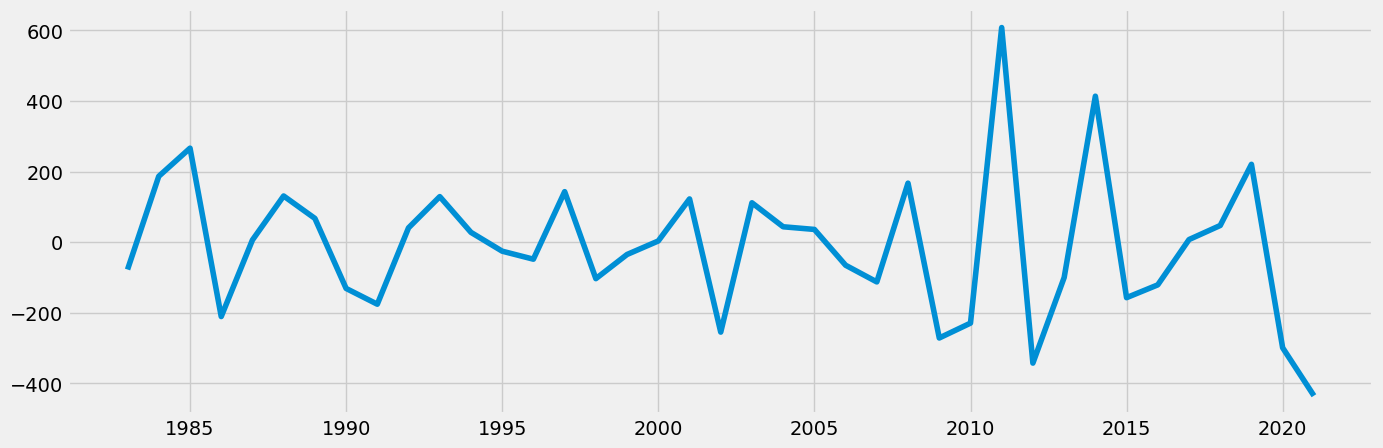

In [32]:
# Plot the new time series

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_co2_stat_2)

#### Now let's start the third round of testing.

# 8. Testing: third round

## 8.1 Stationarity Test

In [33]:
# Apply the test to the new time series

dickey_fuller(data_co2_stat_2['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -3.887125
p-value                         0.002132
Number of Lags Used             6.000000
Number of Observations Used    32.000000
Critical Value (1%)            -3.653520
Critical Value (5%)            -2.957219
Critical Value (10%)           -2.617588
dtype: float64


#### Interpretation of the test results:
#### Now the p-value is smaller than 0.05 and the Test Statistic value is smaller than the Critical Value (5%).
#### Based on the test results, we can reject the Null hypothesis and affirm with a 95% interval of confidence that this new time series is stationary. 
#### Because the properties of a stationary time series do not change over time, this time series could be used for forecasting.
#### Finally, let's run another autocorrelation test on the new time series.

## 8.2 Autocorrelation Test

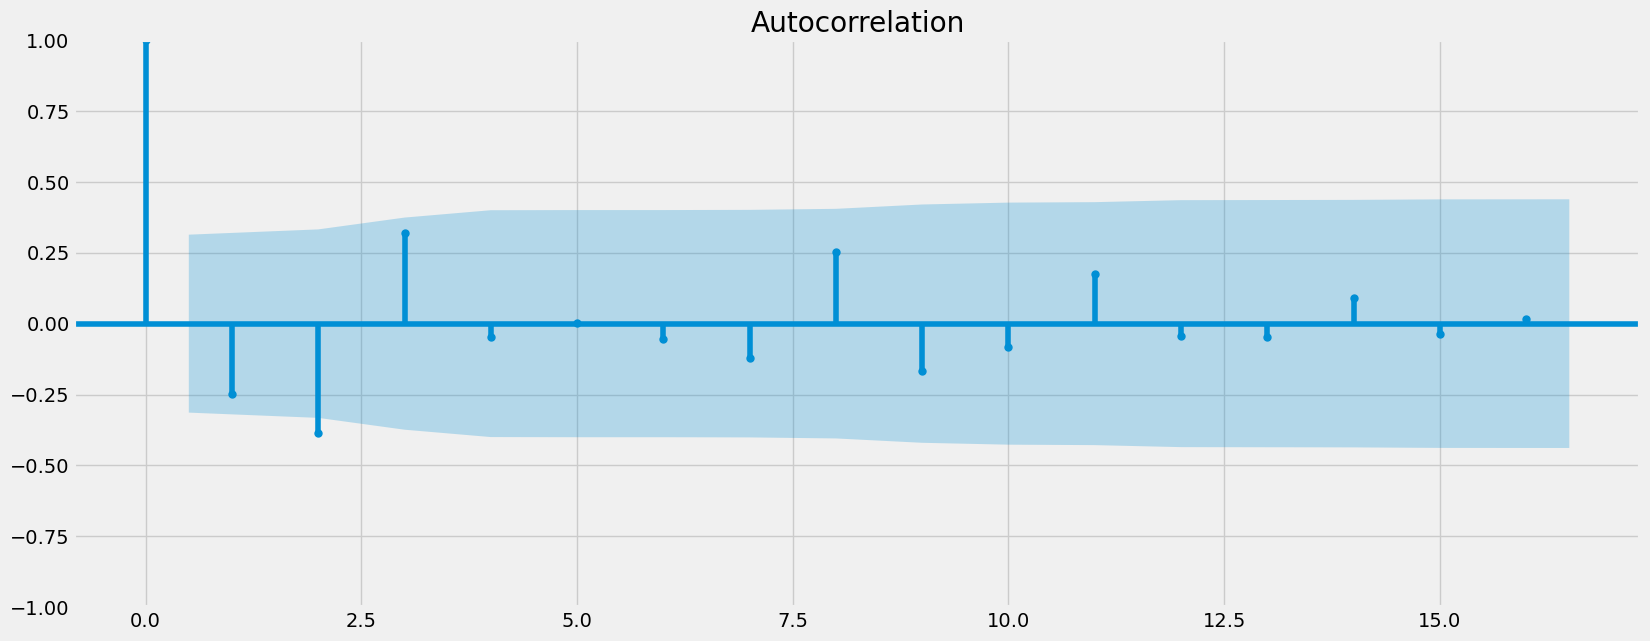

In [34]:
# Run the autocorrelation test on the new time series

plot_acf(data_co2_stat_2)
plt.show()

#### In this plot there are less autocorrelated terms which means that not only the time series is stationary now, but also autocorrelation has decreased as well. Now, we can only observe two lags above the confidence interval. 